In [1]:
import os

In [2]:
# list of flowers
path = "../data/flowers/"
flower_list = os.listdir(path)
print(flower_list)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


##### Importing Various Modules

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # K-Folds cross-validator
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


#### Making the functions to get the training and validation set from the Images 

In [4]:

X=[]
Z=[]

IMG_SIZE=150

FLOWER_DAISY_DIR=path+'daisy'
FLOWER_DANDI_DIR=path+'dandelion'
FLOWER_ROSE_DIR=path+'rose'
FLOWER_SUNFLOWER_DIR=path+'sunflower'
FLOWER_TULIP_DIR=path+'tulip'


In [5]:
# Functio to read read label data
def make_train_data(flower_type,DIR): 
    for img in tqdm(os.listdir(DIR)):
        label= flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        

In [6]:
# funbction call
for i in range (len(flower_list)):
    make_train_data(flower_list[i],path+flower_list[i])


100%|████████████████████████████████████████████████████████████████████████████████| 984/984 [00:11<00:00, 86.03it/s]


#### Visualizing some Random Images

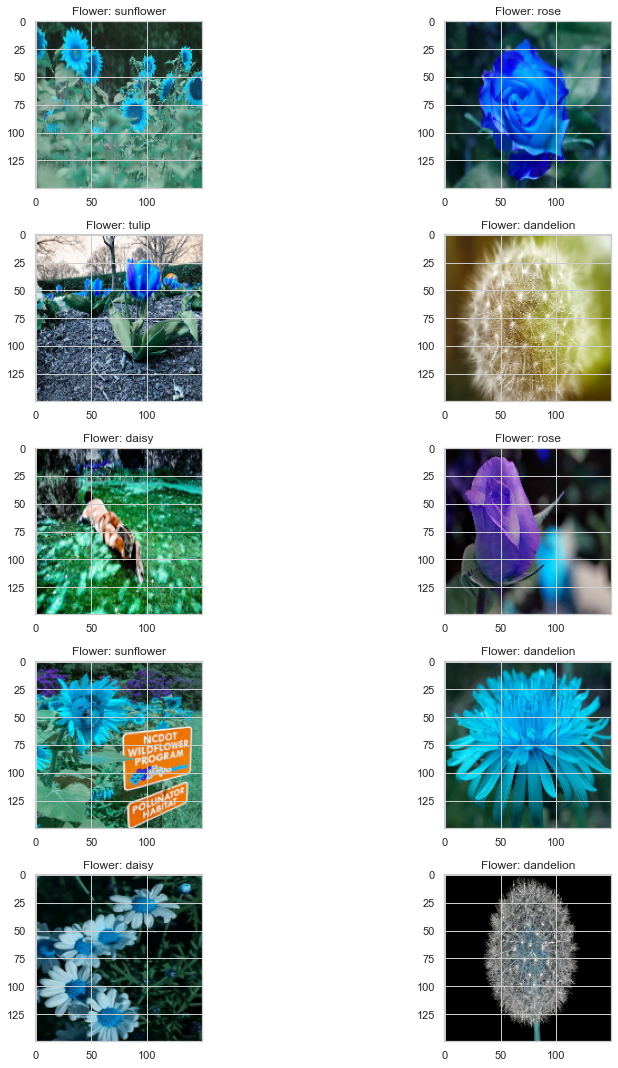

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z)) # select random images from the X
        ax[i,j].imshow(X[l]) #X[l] image 
        ax[i,j].set_title('Flower: '+Z[l]) # Z[l] image name
        
plt.tight_layout()

In [8]:
# LabelEncoding

le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [9]:
# Splitting into Training and Validation Sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


#### Modelling

In [10]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
batch_size=128
epochs=50

#from keras.callbacks import ReduceLROnPlateau
#red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)       

In [15]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test)


Epoch 1/50
25/25 [==============================] - 27s 1s/step - loss: 1.4811 - accuracy: 0.3208 - val_loss: 1.3345 - val_accuracy: 0.4246
Epoch 2/50
25/25 [==============================] - 17s 689ms/step - loss: 1.2499 - accuracy: 0.4464 - val_loss: 1.1512 - val_accuracy: 0.4977
Epoch 3/50
25/25 [==============================] - 17s 666ms/step - loss: 1.1225 - accuracy: 0.5572 - val_loss: 1.1097 - val_accuracy: 0.5708
Epoch 4/50
25/25 [==============================] - 17s 677ms/step - loss: 1.0589 - accuracy: 0.5668 - val_loss: 1.0185 - val_accuracy: 0.5939
Epoch 5/50
25/25 [==============================] - 18s 733ms/step - loss: 0.9820 - accuracy: 0.5983 - val_loss: 1.0811 - val_accuracy: 0.5689
Epoch 6/50
25/25 [==============================] - 18s 726ms/step - loss: 0.9695 - accuracy: 0.6358 - val_loss: 0.9080 - val_accuracy: 0.6512
Epoch 7/50
25/25 [==============================] - 17s 695ms/step - loss: 0.8936 - accuracy: 0.6413 - val_loss: 0.8931 - val_accuracy: 0.6577
E

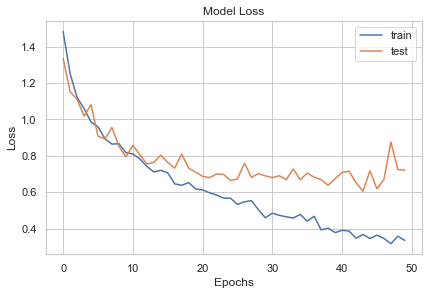

In [16]:
# loss graph

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

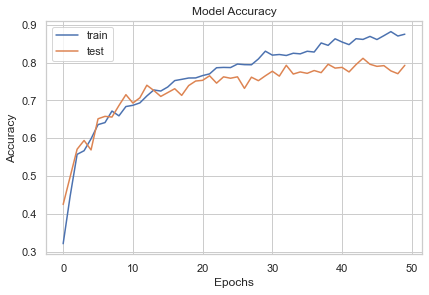

In [17]:
# loss accuracy


plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [18]:
model.save("../model/flower_model.h5")


In [19]:
from keras.models import load_model
from keras.preprocessing import image

In [20]:
# load model
model_load = load_model('../model/flower_model.h5')
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)       

In [21]:
# load image 
img = image.load_img('../images/daisy.jpg',target_size=(150,150,3))

In [22]:
# convert image to array
img = image.img_to_array(img)
img = img/255

In [23]:
# prediction
prediction = model_load.predict(img.reshape(1,150,150,3))
pred_digits=np.argmax(prediction,axis=1)

In [24]:
# prediction score
prediction

array([[1.0000000e+00, 1.3607759e-09, 3.5962209e-09, 2.9021249e-11,
        2.5969404e-08]], dtype=float32)

In [25]:
# find the prediction class having max value 
max_value = max(prediction[0].tolist())
max_index = prediction[0].tolist().index(max(prediction[0].tolist())) 

In [26]:
# Shows the prediction class name 
if max_index ==0:
    print('daisy')
if max_index ==1:
    print('dandelion')
if max_index ==2:
    print('rose')
if max_index ==3:
    print('sunflower')
if max_index ==4:
    print('tulip')

daisy
